## Задание:
1. Выбрать тематику для поиска (например, “machine learning”) и использовать arXiv API для извлечения статей. Выгрузить названия, авторов и аннотации статей.
2. Разбиение на чанки. Разделить текст аннотаций на чанки по 500 слов с перекрытием в 50 слов для последующей обработки.
3. Векторизация текста. Использовать модель эмбеддингов (например, ‘all-MiniLM-L6-v2’) для преобразования текстов в векторное представление. Построить векторное хранилище с помощью FAISS.
4. Интеграция с LLM. Настроить взаимодействие с LLM (например, FLAN-T5 или OpenAI GPT). Использовать промпт для получения ключевых идей статьи или ответа на конкретный вопрос пользователя.
5. Поиск по корпусу. Настроить промпт-инжиниринг для извлечения ключевых идей и результатов из текста. Добавить обработку опечаток в пользовательских запросах с использованием библиотек типа SymSpell или rapidfuzz.

In [1]:
!pip install feedparser pandas fastparquet bs4 pypdf2 pdfplumber

In [2]:
import feedparser
import urllib.request as libreq
import feedparser
import re
import time
import pandas as pd
import PyPDF2
import io
from bs4 import BeautifulSoup
import pdfplumber
from concurrent.futures import ThreadPoolExecutor

In [3]:
CATEGORY = "math.ST"
RESULTS = 260  
BASE_URL = "http://export.arxiv.org/api/query?"
BATCH_SIZE = 10 

In [4]:
def extract_keywords(text):
    """Ищем ключевые слова в тексте."""
    keywords_match = re.search(r'(?i)(?:keywords?|KEYWORDS?):\s*([^\n]+)', text, re.IGNORECASE | re.DOTALL)
    if keywords_match:
        return [kw.strip() for kw in keywords_match.group(1).split(',')]
    return None

def fetch_keywords_from_pdf(pdf_url):
    """Скачиваем PDF, извлекаем текст, ищем Keywords."""
    try:
        with libreq.urlopen(pdf_url) as response:
            pdf_data = response.read()

        with pdfplumber.open(io.BytesIO(pdf_data)) as pdf:
            full_text = "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())

        return extract_keywords(full_text)

    except Exception as e:
        print(f"Ошибка скачивания/парсинга PDF: {e}")
        return None

def fetch_arxiv_papers(category, max_results=RESULTS, batch_size=BATCH_SIZE):
    papers = []

    def process_paper(entry):
        abs_url = entry.id
        pdf_url = abs_url.replace("abs", "pdf")  
        keywords = fetch_keywords_from_pdf(pdf_url) 

        return {
            "title": entry.title,
            "authors": [author.name for author in entry.authors],
            "summary": entry.summary,
            "keywords": keywords
        }

    with ThreadPoolExecutor() as executor:
        for start in range(0, max_results, batch_size):
            query = f"search_query=cat:{category}&start={start}&max_results={batch_size}&sortBy=submittedDate&sortOrder=descending"
            url = BASE_URL + query

            with libreq.urlopen(url) as response:
                data = response.read()

            feed = feedparser.parse(data)

            results = list(executor.map(process_paper, feed.entries))

            papers.extend(results)

            time.sleep(1)  
    
    return papers

In [5]:
papers = fetch_arxiv_papers(CATEGORY)

Ошибка скачивания/парсинга PDF: HTTP Error 404: Not Found


In [6]:
papers

[{'title': 'Nonparametric local polynomial regression for functional covariates',
  'authors': ['Moritz Jirak',
   'Alois Kneip',
   'Alexander Meister',
   'Mario Pahl'],
  'summary': 'We consider nonparametric regression with functional covariates, that is,\nthey are elements of an infinite-dimensional Hilbert space. A locally\npolynomial estimator is constructed, where an orthonormal basis and various\ntuning parameters remain to be selected. We provide a general asymptotic upper\nbound on the estimation error and show that this procedure achieves polynomial\nconvergence rates under appropriate tuning and supersmoothness of the\nregression function. Such polynomial convergence rates have usually been\nconsidered to be non-attainable in nonparametric functional regression without\nany additional strong structural constraints such as linearity of the\nregression function.',
  'keywords': ['functional data analysis; kernel estimation; nonparametric regression; polyno-']},
 {'title': 'R

In [7]:
print(f"Всего найдено статей с ключевыми словами: {sum(1 for p in papers if p['keywords'])}")

Всего найдено статей с ключевыми словами: 90


In [8]:
len(papers)

250

In [9]:
df = pd.DataFrame(papers)

In [10]:
df.sample(5)

,title,authors,summary,keywords
70,Rolled Gaussian process models for curves on m...,"[Simon Preston, Karthik Bharath, Pablo Lopez-C...","Given a planar curve, imagine rolling a sphere...",None
72,Locally minimax optimal and dimension-agnostic...,"[Ilmun Kim, Aaditya Ramdas]",We revisit the discrete argmin inference probl...,None
46,Power comparison of sequential testing by bett...,"[Amaury Durand, Olivier Wintenberger]","In this paper, we derive power guarantees of s...",None
237,Testing Thresholds and Spectral Properties of ...,"[Samuel Baguley, Andreas Göbel, Marcus Pappik,...",We study high-dimensional random geometric gra...,None
3,Debiasing Continuous-time Nonlinear Autoregres...,"[Simon Kuang, Xinfan Lin]",We study how to identify a class of continuous...,[systemidentification]


In [11]:
df.keywords.isna().sum()

np.int64(160)

In [12]:
df.to_parquet('data.parquet.gzip', compression='gzip')

In [13]:
df = pd.read_parquet('data.parquet.gzip')

In [14]:
!pip install yake networkx matplotlib scipy seaborn textblob stanza

In [15]:
import yake
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import itertools
import seaborn as sns
from textblob import Word
import stanza
import nltk
from nltk.corpus import stopwords

In [16]:
yake_extractor = yake.KeywordExtractor(lan="en", n=4, dedupLim=0.85, top=20)

In [17]:
def extract_keywords(text):
    text = text.lower()
    keywords = yake_extractor.extract_keywords(text)
    return [kw[0] for kw in keywords]

def update_keywords(row):
    existing_keywords = set(row["keywords"]) if isinstance(row["keywords"], list) else set()
    new_keywords = set(extract_keywords(row["title"] + " " + row["summary"]))
    
    updated_keywords = list(existing_keywords | new_keywords) 
    return updated_keywords

In [18]:
df["keywords"] = df.apply(update_keywords, axis=1)

In [19]:
df[['title', 'keywords']].head(5)

,title,keywords
0,Nonparametric local polynomial regression for ...,"[space, polynomial, nonparametric local, hilbe..."
1,Revisiting poverty measures using quantile fun...,"[flexible quantile function models, measures i..."
2,Online Bernstein-von Mises theorem,"[sequentially updated posterior, updated poste..."
3,Debiasing Continuous-time Nonlinear Autoregres...,"[debiasing continuous-time nonlinear, ordinary..."
4,A Generalized Tangent Approximation Framework ...,"[framework for strongly super-gaussian, analys..."


In [20]:
df.iloc[1].keywords

['flexible quantile function models',
 'measures in literature',
 'revisiting poverty measures',
 'revisiting poverty',
 'quantile functions',
 'distribution functions',
 'measures using quantile functions',
 'redefine various poverty measures',
 'terms of quantile functions',
 'poverty measures in literature',
 'poverty',
 'measures',
 'article we redefine',
 'literature in terms',
 'flexible quantile function',
 'poverty measures',
 'quantile function models',
 'poverty measurement and analysis',
 'prevailing approach',
 'poverty measures using quantile']

In [21]:
stanza.download('en')
nlp = stanza.Pipeline('en')

def lemmatize_keywords_stanza(keywords):
    lemmatized_phrases = []
    
    for phrase in keywords:
        doc = nlp(phrase) 
        lemmatized_words = [word.lemma for word in doc.iter_words()]
        lemmatized_phrases.append(" ".join(lemmatized_words)) 
    
    return lemmatized_phrases

2025-04-09 16:23:28 INFO: Downloaded file to /Users/maksvell/stanza_resources/resources.json
2025-04-09 16:23:28 INFO: Downloading default packages for language: en (English) ...


2025-04-09 16:24:25 INFO: Downloaded file to /Users/maksvell/stanza_resources/en/default.zip
2025-04-09 16:24:26 INFO: Finished downloading models and saved to /Users/maksvell/stanza_resources
2025-04-09 16:24:26 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-09 16:24:27 INFO: Downloaded file to /Users/maksvell/stanza_resources/resources.json
2025-04-09 16:24:28 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2025-04-09 16:24:28 INFO: Using device: cpu
2025-04-09 16:24:28 INFO: Loading: tokenize
2025-04-09 16:24:28 INFO: Loading: mwt
2025-04-09 16:24:28 INFO: Loading: pos
2025-04-09 16:24:29 INFO: Loading: lemma
2025-04-09 16:24:29 INFO: Loading: constituency
2025-04-09 16:24:29 INFO: Loading: depparse
2025-04-09 16:24:30 INFO: Loading: sentiment
2025-04-09 16:24:30 INFO: Loading: ne

In [22]:
df['lemmatized_keywords'] = df['keywords'].apply(lambda row: lemmatize_keywords_stanza(row))

In [23]:
df.head(5)

,title,authors,summary,keywords,lemmatized_keywords
0,Nonparametric local polynomial regression for ...,"[Moritz Jirak, Alois Kneip, Alexander Meister,...",We consider nonparametric regression with func...,"[space, polynomial, nonparametric local, hilbe...","[space, polynomial, nonparametric local, hilbe..."
1,Revisiting poverty measures using quantile fun...,"[N. Unnikrishnan Nair, S. M. Sunoj]",In this article we redefine various poverty me...,"[flexible quantile function models, measures i...","[flexible quantile function model, measure in ..."
2,Online Bernstein-von Mises theorem,"[Jeyong Lee, Junhyeok Choi, Minwoo Chae]",Online learning is an inferential paradigm in ...,"[sequentially updated posterior, updated poste...","[sequentially update posterior, update posteri..."
3,Debiasing Continuous-time Nonlinear Autoregres...,"[Simon Kuang, Xinfan Lin]",We study how to identify a class of continuous...,"[debiasing continuous-time nonlinear, ordinary...","[debiase continuous - time nonlinear, ordinary..."
4,A Generalized Tangent Approximation Framework ...,"[Somjit Roy, Pritam Dey, Debdeep Pati, Bani K....",Tangent approximation form a popular class of ...,"[framework for strongly super-gaussian, analys...","[framework for strongly super - gaussian, anal..."


In [24]:
df[['keywords', 'lemmatized_keywords']].iloc[1].values

array([list(['flexible quantile function models', 'measures in literature', 'revisiting poverty measures', 'revisiting poverty', 'quantile functions', 'distribution functions', 'measures using quantile functions', 'redefine various poverty measures', 'terms of quantile functions', 'poverty measures in literature', 'poverty', 'measures', 'article we redefine', 'literature in terms', 'flexible quantile function', 'poverty measures', 'quantile function models', 'poverty measurement and analysis', 'prevailing approach', 'poverty measures using quantile']),
       list(['flexible quantile function model', 'measure in literature', 'revisit poverty measure', 'revisit poverty', 'quantile function', 'distribution function', 'measure use quantile function', 'redefine various poverty measure', 'term of quantile function', 'poverty measure in literature', 'poverty', 'measure', 'article we redefine', 'literature in term', 'flexible quantile function', 'poverty measure', 'quantile function model', '

In [25]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksvell/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
def clean_keywords(keywords):
    cleaned_keywords = []
    
    for phrase in keywords:
        words = phrase.split() 
        filtered_words = [word for word in words if word not in stop_words]
        
        if filtered_words:
            cleaned_keywords.append(" ".join(filtered_words))
    
    return cleaned_keywords

In [27]:
df['cleaned_keywords'] = df['lemmatized_keywords'].apply(clean_keywords)

In [28]:
df.iloc[1].cleaned_keywords

['flexible quantile function model',
 'measure literature',
 'revisit poverty measure',
 'revisit poverty',
 'quantile function',
 'distribution function',
 'measure use quantile function',
 'redefine various poverty measure',
 'term quantile function',
 'poverty measure literature',
 'poverty',
 'measure',
 'article redefine',
 'literature term',
 'flexible quantile function',
 'poverty measure',
 'quantile function model',
 'poverty measurement analysis',
 'prevail approach',
 'poverty measure use quantile']

In [29]:
df.sample(5)

,title,authors,summary,keywords,lemmatized_keywords,cleaned_keywords
129,Dynamic Investment Strategies Through Market C...,"[Jinhui Li, Wenjia Xie, Luis Seco]",This study introduces a dynamic investment fra...,"[learning approach this study, enhance portfol...","[learn approach this study, enhance portfolio ...","[learn approach study, enhance portfolio manag..."
4,A Generalized Tangent Approximation Framework ...,"[Somjit Roy, Pritam Dey, Debdeep Pati, Bani K....",Tangent approximation form a popular class of ...,"[framework for strongly super-gaussian, analys...","[framework for strongly super - gaussian, anal...","[framework strongly super - gaussian, analysis..."
158,Training Diagonal Linear Networks with Stochas...,"[Gabriel Clara, Sophie Langer, Johannes Schmid...",We analyze the landscape and training dynamics...,"[training dynamics, perturbed by small isotrop...","[training dynamic, perturb by small isotropic,...","[training dynamic, perturb small isotropic, li..."
21,Existence and non-existence of consistent esti...,"[Peter Braunsteins, Sophie Hautphenne, James K...",We consider the problem of estimating the para...,"[non-existence of consistent, consistently est...","[non-existence of consistent, consistently est...","[non-existence consistent, consistently estima..."
17,Identifiability of VAR(1) model in a stationar...,[Bixuan Liu],We consider a classical First-order Vector Aut...,"[weighted directed, components of the var, vec...","[weight direct, component of the var, vector a...","[weight direct, component var, vector autoregr..."


In [30]:
all_keywords = [word for keywords in df['cleaned_keywords'] for word in keywords]
keyword_freq = Counter(all_keywords)

most_common_keywords = keyword_freq.most_common(50)
print(most_common_keywords)

[('model', 10), ('time series', 10), ('process', 8), ('regression', 6), ('distribution', 6), ('gaussian', 6), ('random variable', 6), ('confidence', 6), ('statistical inference', 6), ('stochastic', 6), ('estimation', 5), ('probability distribution', 5), ('linear regression', 5), ('random', 5), ('confidence set', 5), ('causal', 5), ('datum', 5), ('network', 5), ('regression model', 4), ('sigma', 4), ('machine learning', 4), ('mathcal', 4), ('conformal prediction', 4), ('empirical', 4), ('time', 4), ('sample size', 4), ('theorem', 4), ('sample', 4), ('learning', 4), ('random graph', 4), ('estimator', 4), ('confidence interval', 4), ('hilbert space', 3), ('convergence rate', 3), ('functional', 3), ('measure', 3), ('differential equation', 3), ('play important role', 3), ('sequential', 3), ('testing', 3), ('white noise', 3), ('neural network', 3), ('hypothesis testing', 3), ('set', 3), ('delta', 3), ('paper introduce', 3), ('random vector', 3), ('test', 3), ('high - dimensional setting', 3

/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_92616/3615611862.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")


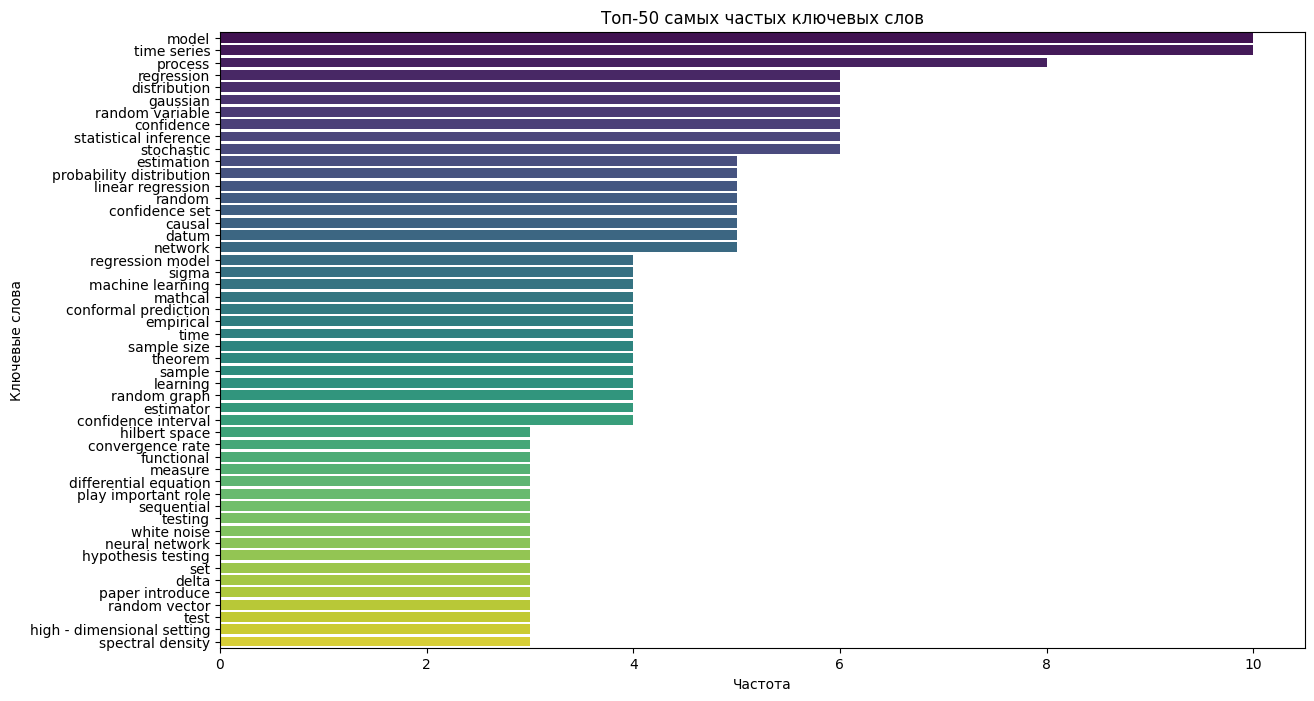

In [31]:
top_keywords = dict(most_common_keywords)
plt.figure(figsize=(14, 8))
sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")
plt.xlabel('Частота')
plt.ylabel('Ключевые слова')
plt.title('Топ-50 самых частых ключевых слов')
plt.show()

In [32]:
unique_keywords = set([word for keywords in df['lemmatized_keywords'] for word in keywords])

print(f"Количество уникальных лемм: {len(unique_keywords)}")

Количество уникальных лемм: 4629


In [33]:
df.to_parquet("preprocessed_data.parquet.gzip", compression='gzip')

In [34]:
df

,title,authors,summary,keywords,lemmatized_keywords,cleaned_keywords
0,Nonparametric local polynomial regression for ...,"[Moritz Jirak, Alois Kneip, Alexander Meister,...",We consider nonparametric regression with func...,"[space, polynomial, nonparametric local, hilbe...","[space, polynomial, nonparametric local, hilbe...","[space, polynomial, nonparametric local, hilbe..."
1,Revisiting poverty measures using quantile fun...,"[N. Unnikrishnan Nair, S. M. Sunoj]",In this article we redefine various poverty me...,"[flexible quantile function models, measures i...","[flexible quantile function model, measure in ...","[flexible quantile function model, measure lit..."
2,Online Bernstein-von Mises theorem,"[Jeyong Lee, Junhyeok Choi, Minwoo Chae]",Online learning is an inferential paradigm in ...,"[sequentially updated posterior, updated poste...","[sequentially update posterior, update posteri...","[sequentially update posterior, update posteri..."
3,Debiasing Continuous-time Nonlinear Autoregres...,"[Simon Kuang, Xinfan Lin]",We study how to identify a class of continuous...,"[debiasing continuous-time nonlinear, ordinary...","[debiase continuous - time nonlinear, ordinary...","[debiase continuous - time nonlinear, ordinary..."
4,A Generalized Tangent Approximation Framework ...,"[Somjit Roy, Pritam Dey, Debdeep Pati, Bani K....",Tangent approximation form a popular class of ...,"[framework for strongly super-gaussian, analys...","[framework for strongly super - gaussian, anal...","[framework strongly super - gaussian, analysis..."
...,...,...,...,...,...,...
245,Optimal Recovery Meets Minimax Estimation,"[Ronald DeVore, Robert D. Nowak, Rahul Parhi, ...",A fundamental problem in statistics and machin...,"[recovery, estimation a fundamental problem, r...","[recovery, estimation a fundamental problem, r...","[recovery, estimation fundamental problem, rat..."
246,Stronger Neyman Regret Guarantees for Adaptive...,"[Georgy Noarov, Riccardo Fogliato, Martin Bert...","We study the design of adaptive, sequential ex...","[potential outcomes, treatment effect, potenti...","[potential outcome, treatment effect, potentia...","[potential outcome, treatment effect, potentia..."
247,Invariance principle for the Gaussian Multipli...,"[Mriganka Basu Roy Chowdhury, Shirshendu Ganguly]",Gaussian multiplicative chaos (GMC) is a canon...,"[random fractal measure obtained, non-gaussian...","[random fractal measure obtain, non-gaussian l...","[random fractal measure obtain, non-gaussian l..."
248,On a class of high dimensional linear regressi...,"[Ying-Ao Wang, Yunyi Zhang, Ye Zhang]","In this paper, we introduce a unified framewor...","[inspired by classical, broad class of linear,...","[inspire by classical, broad class of linear, ...","[inspire classical, broad class linear, method..."


In [46]:
df.columns

Index(['title', 'authors', 'summary', 'keywords', 'lemmatized_keywords',
       'cleaned_keywords'],
      dtype='object')

In [35]:
full_text = " ".join(df["summary"].tolist())

In [36]:
full_text

'We consider nonparametric regression with functional covariates, that is,\nthey are elements of an infinite-dimensional Hilbert space. A locally\npolynomial estimator is constructed, where an orthonormal basis and various\ntuning parameters remain to be selected. We provide a general asymptotic upper\nbound on the estimation error and show that this procedure achieves polynomial\nconvergence rates under appropriate tuning and supersmoothness of the\nregression function. Such polynomial convergence rates have usually been\nconsidered to be non-attainable in nonparametric functional regression without\nany additional strong structural constraints such as linearity of the\nregression function. In this article we redefine various poverty measures in literature in terms\nof quantile functions instead of distribution functions in the prevailing\napproach. This enables provision for alternative methodology for poverty\nmeasurement and analysis along with some new results that are difficult t

In [37]:
len(full_text)

268250

In [38]:
words = full_text.split()

In [39]:
words

['We',
 'consider',
 'nonparametric',
 'regression',
 'with',
 'functional',
 'covariates,',
 'that',
 'is,',
 'they',
 'are',
 'elements',
 'of',
 'an',
 'infinite-dimensional',
 'Hilbert',
 'space.',
 'A',
 'locally',
 'polynomial',
 'estimator',
 'is',
 'constructed,',
 'where',
 'an',
 'orthonormal',
 'basis',
 'and',
 'various',
 'tuning',
 'parameters',
 'remain',
 'to',
 'be',
 'selected.',
 'We',
 'provide',
 'a',
 'general',
 'asymptotic',
 'upper',
 'bound',
 'on',
 'the',
 'estimation',
 'error',
 'and',
 'show',
 'that',
 'this',
 'procedure',
 'achieves',
 'polynomial',
 'convergence',
 'rates',
 'under',
 'appropriate',
 'tuning',
 'and',
 'supersmoothness',
 'of',
 'the',
 'regression',
 'function.',
 'Such',
 'polynomial',
 'convergence',
 'rates',
 'have',
 'usually',
 'been',
 'considered',
 'to',
 'be',
 'non-attainable',
 'in',
 'nonparametric',
 'functional',
 'regression',
 'without',
 'any',
 'additional',
 'strong',
 'structural',
 'constraints',
 'such',
 'as',

In [40]:
len(words)

37878

In [41]:
def split_into_chunks(words, chunk_size=500, overlap=50):
    chunks = []
    start = 0
    while start < len(words):
        end = start + chunk_size
        chunk = words[start:end]
        chunks.append(" ".join(chunk))
        start += chunk_size - overlap  
    return chunks

In [42]:
chunks = split_into_chunks(words)

In [43]:
chunks

['We consider nonparametric regression with functional covariates, that is, they are elements of an infinite-dimensional Hilbert space. A locally polynomial estimator is constructed, where an orthonormal basis and various tuning parameters remain to be selected. We provide a general asymptotic upper bound on the estimation error and show that this procedure achieves polynomial convergence rates under appropriate tuning and supersmoothness of the regression function. Such polynomial convergence rates have usually been considered to be non-attainable in nonparametric functional regression without any additional strong structural constraints such as linearity of the regression function. In this article we redefine various poverty measures in literature in terms of quantile functions instead of distribution functions in the prevailing approach. This enables provision for alternative methodology for poverty measurement and analysis along with some new results that are difficult to obtain in

In [44]:
df_chunks = pd.DataFrame({"chunk": chunks})

In [45]:
df_chunks

,chunk
0,We consider nonparametric regression with func...
1,corrections that improve the accuracy for fini...
2,parametric estimation of multimodal densities ...
3,"events from baseline. Unlike existing models, ..."
4,"much less understood, and the focus of our wor..."
...,...
80,a family of robust filters of which the signed...
81,"transfer learning. Under this setting, we prop..."
82,statistics and machine learning is to estimate...
83,of Kahane (1985). Since then it has served as ...


In [47]:
def make_enriched_chunks(df, chunk_size=500, overlap=50):
    enriched_rows = []

    for article_id, row in df.iterrows():
        title = row["title"]
        authors = ", ".join(row["authors"])
        keywords = ", ".join(row["cleaned_keywords"]) if isinstance(row["cleaned_keywords"], list) else ""
        summary_words = row["summary"].split()
        chunks = split_into_chunks(summary_words, chunk_size, overlap)

        for chunk_idx, chunk_text in enumerate(chunks):
            enriched_text = f"Title: {title}\nAuthors: {authors}\nKeywords: {keywords}\nText: {chunk_text}"
            enriched_rows.append({
                "article_id": article_id,
                "chunk_id": chunk_idx,
                "title": title,
                "authors": authors,
                "keywords": keywords,
                "chunk": chunk_text,
                "enriched_text": enriched_text
            })

    return pd.DataFrame(enriched_rows)

In [48]:
df_enriched_chunks = make_enriched_chunks(df)

In [49]:
df_enriched_chunks

,article_id,chunk_id,title,authors,keywords,chunk,enriched_text
0,0,0,Nonparametric local polynomial regression for ...,"Moritz Jirak, Alois Kneip, Alexander Meister, ...","space, polynomial, nonparametric local, hilber...",We consider nonparametric regression with func...,Title: Nonparametric local polynomial regressi...
1,1,0,Revisiting poverty measures using quantile fun...,"N. Unnikrishnan Nair, S. M. Sunoj","flexible quantile function model, measure lite...",In this article we redefine various poverty me...,Title: Revisiting poverty measures using quant...
2,2,0,Online Bernstein-von Mises theorem,"Jeyong Lee, Junhyeok Choi, Minwoo Chae","sequentially update posterior, update posterio...",Online learning is an inferential paradigm in ...,Title: Online Bernstein-von Mises theorem\nAut...
3,3,0,Debiasing Continuous-time Nonlinear Autoregres...,"Simon Kuang, Xinfan Lin","debiase continuous - time nonlinear, ordinary ...",We study how to identify a class of continuous...,Title: Debiasing Continuous-time Nonlinear Aut...
4,4,0,A Generalized Tangent Approximation Framework ...,"Somjit Roy, Pritam Dey, Debdeep Pati, Bani K. ...","framework strongly super - gaussian, analysis ...",Tangent approximation form a popular class of ...,Title: A Generalized Tangent Approximation Fra...
...,...,...,...,...,...,...,...
245,245,0,Optimal Recovery Meets Minimax Estimation,"Ronald DeVore, Robert D. Nowak, Rahul Parhi, G...","recovery, estimation fundamental problem, rate...",A fundamental problem in statistics and machin...,Title: Optimal Recovery Meets Minimax Estimati...
246,246,0,Stronger Neyman Regret Guarantees for Adaptive...,"Georgy Noarov, Riccardo Fogliato, Martin Bertr...","potential outcome, treatment effect, potential...","We study the design of adaptive, sequential ex...",Title: Stronger Neyman Regret Guarantees for A...
247,247,0,Invariance principle for the Gaussian Multipli...,"Mriganka Basu Roy Chowdhury, Shirshendu Ganguly","random fractal measure obtain, non-gaussian lo...",Gaussian multiplicative chaos (GMC) is a canon...,Title: Invariance principle for the Gaussian M...
248,248,0,On a class of high dimensional linear regressi...,"Ying-Ao Wang, Yunyi Zhang, Ye Zhang","inspire classical, broad class linear, method,...","In this paper, we introduce a unified framewor...",Title: On a class of high dimensional linear r...


In [51]:
from collections import defaultdict

In [52]:
article_chunks = df_enriched_chunks.groupby("article_id")["chunk"].apply(lambda chunks: " ".join(chunks)).to_dict()

In [53]:
article_chunks

{0: 'We consider nonparametric regression with functional covariates, that is, they are elements of an infinite-dimensional Hilbert space. A locally polynomial estimator is constructed, where an orthonormal basis and various tuning parameters remain to be selected. We provide a general asymptotic upper bound on the estimation error and show that this procedure achieves polynomial convergence rates under appropriate tuning and supersmoothness of the regression function. Such polynomial convergence rates have usually been considered to be non-attainable in nonparametric functional regression without any additional strong structural constraints such as linearity of the regression function.',
 1: 'In this article we redefine various poverty measures in literature in terms of quantile functions instead of distribution functions in the prevailing approach. This enables provision for alternative methodology for poverty measurement and analysis along with some new results that are difficult to

In [54]:
def update_keywords_with_chunks(row):
    article_id = row.name
    original_keywords = set(row["cleaned_keywords"]) if isinstance(row["cleaned_keywords"], list) else set()
    
    chunk_text = article_chunks.get(article_id, "")
    new_keywords = extract_keywords(chunk_text)
    new_keywords_lemmatized = lemmatize_keywords_stanza(new_keywords)
    new_keywords_cleaned = clean_keywords(new_keywords_lemmatized)

    combined = original_keywords.union(new_keywords_cleaned)
    return list(combined)

In [55]:
df["enriched_keywords"] = df.apply(update_keywords_with_chunks, axis=1)

In [56]:
def update_enriched_text(row):
    new_keywords = ", ".join(df.loc[row.article_id, "enriched_keywords"])
    return f"Title: {row.title}\nAuthors: {row.authors}\nKeywords: {new_keywords}\nText: {row.chunk}"

df_enriched_chunks["enriched_text"] = df_enriched_chunks.apply(update_enriched_text, axis=1)

In [57]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /Users/maksvell/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [58]:
def lemmatize_and_clean_text(text):
    doc = nlp(text.lower())
    words = [word.lemma for word in doc.iter_words() if word.lemma not in stop_words and word.lemma.isalpha()]
    return " ".join(words)

df_enriched_chunks["chunk_lemmatized"] = df_enriched_chunks["chunk"].apply(lemmatize_and_clean_text)

In [59]:
def get_summary_intro(article_id):
    try:
        summary = df.loc[article_id, "summary"]
        sentences = sent_tokenize(summary)
        return " ".join(sentences[:2]) 
    except:
        return ""
    
df_enriched_chunks["summary_intro"] = df_enriched_chunks["article_id"].apply(get_summary_intro)

In [60]:
def get_topic_from_keywords(article_id):
    keywords = df.loc[article_id, "enriched_keywords"]
    return keywords[0] if isinstance(keywords, list) and len(keywords) > 0 else "other"

df_enriched_chunks["topic"] = df_enriched_chunks["article_id"].apply(get_topic_from_keywords)

In [61]:
def make_rich_enriched_text(row):
    enriched_keywords = ", ".join(df.loc[row.article_id, "enriched_keywords"])
    return (
        f"Title: {row.title}\n"
        f"Authors: {row.authors}\n"
        f"Topic: {row.topic}\n"
        f"Keywords: {enriched_keywords}\n"
        f"Intro: {row.summary_intro}\n"
        f"Lemmatized Chunk: {row.chunk_lemmatized}"
    )

df_enriched_chunks["enriched_text_rich"] = df_enriched_chunks.apply(make_rich_enriched_text, axis=1)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df_enriched_chunks["chunk_lemmatized"])
feature_names = vectorizer.get_feature_names_out()

top_terms = []
for row in tfidf_matrix:
    row_data = row.toarray().flatten()
    top_indices = row_data.argsort()[-5:][::-1]  
    top_words = [feature_names[i] for i in top_indices if row_data[i] > 0]
    top_terms.append(", ".join(top_words))

In [65]:
df_enriched_chunks["tfidf_top_terms"] = top_terms

In [68]:
df_final_chunks = df_enriched_chunks[[
    "article_id", "title", "authors", "topic",
    "summary_intro", "keywords", "chunk", "chunk_lemmatized",
    "enriched_text_rich", "tfidf_top_terms"
]]

In [69]:
df_final_chunks.sample(5)

,article_id,title,authors,topic,summary_intro,keywords,chunk,chunk_lemmatized,enriched_text_rich,tfidf_top_terms
213,213,Systemic Risk Management via Maximum Independe...,"Qian Hui, Tiandong Wang",financial institution may accelerate,,"risk management, key financial institution, sy...",The failure of key financial institutions may ...,failure key financial institution may accelera...,Title: Systemic Risk Management via Maximum In...,"institution, financial, extremal, dependence, ..."
202,202,Generalizability of Neural Networks Minimizing...,"Lijia Yu, Yibo Miao, Yifan Zhu, Xiao-Shan Gao,...",learn exhibit nice generalizability,,"minimize empirical, generalizability, learn ex...",The primary objective of learning methods is g...,primary objective learning method generalizati...,Title: Generalizability of Neural Networks Min...,"generalization, network, deep, minimize, learning"
187,187,The level of self-organized criticality in osc...,"Johannes Brutsche, Angelika Rohde",rho,,"rho, self - organize criticality, self - organ...",For some discretely observed path of oscillati...,discretely observe path oscillate brownian mot...,Title: The level of self-organized criticality...,"mle, argument, process, local, limit"
200,200,Learning Causal Response Representations throu...,"Homer Durand, Gherardo Varando, Gustau Camps-V...",conditional independence,,"conditional independence, learn causal respons...",We propose a novel approach for learning causa...,propose novel approach learn causal response r...,Title: Learning Causal Response Representation...,"independence, representation, causal, conditio..."
165,165,A New Design-Based Variance Estimator for Fine...,"Yuehao Bai, Xun Huang, Joseph P. Romano, Azeem...",treatment effect,,"variance estimator finely, treatment effect fi...",This paper considers the problem of design-bas...,paper consider problem design base inference a...,Title: A New Design-Based Variance Estimator f...,"estimator, stratify, treatment, biased, quality"


In [72]:
df_final_chunks.summary_intro.value_counts()

summary_intro
    250
Name: count, dtype: int64

In [73]:
df_final_chunks = df_final_chunks.drop('summary_intro', axis=1)

In [74]:
df_final_chunks

,article_id,title,authors,topic,keywords,chunk,chunk_lemmatized,enriched_text_rich,tfidf_top_terms
0,0,Nonparametric local polynomial regression for ...,"Moritz Jirak, Alois Kneip, Alexander Meister, ...",space,"space, polynomial, nonparametric local, hilber...",We consider nonparametric regression with func...,consider nonparametric regression functional c...,Title: Nonparametric local polynomial regressi...,"regression, polynomial, tuning, functional, no..."
1,1,Revisiting poverty measures using quantile fun...,"N. Unnikrishnan Nair, S. M. Sunoj",redefine various poverty,"flexible quantile function model, measure lite...",In this article we redefine various poverty me...,article redefine various poverty measure liter...,Title: Revisiting poverty measures using quant...,"quantile, function, exist, difficult, flexible"
2,2,Online Bernstein-von Mises theorem,"Jeyong Lee, Junhyeok Choi, Minwoo Chae",bernstein - von mise theorem,"sequentially update posterior, update posterio...",Online learning is an inferential paradigm in ...,online learning inferential paradigm parameter...,Title: Online Bernstein-von Mises theorem\nAut...,"update, posterior, batch, sequentially, step"
3,3,Debiasing Continuous-time Nonlinear Autoregres...,"Simon Kuang, Xinfan Lin",class continuous - time system,"debiase continuous - time nonlinear, ordinary ...",We study how to identify a class of continuous...,study identify class continuous time nonlinear...,Title: Debiasing Continuous-time Nonlinear Aut...,"step, direct, continuous, time, second"
4,4,A Generalized Tangent Approximation Framework ...,"Somjit Roy, Pritam Dey, Debdeep Pati, Bani K. ...",approximation base variational inference,"framework strongly super - gaussian, analysis ...",Tangent approximation form a popular class of ...,tangent approximation form popular class varia...,Title: A Generalized Tangent Approximation Fra...,"likelihood, approximation, variational, optima..."
...,...,...,...,...,...,...,...,...,...
245,245,Optimal Recovery Meets Minimax Estimation,"Ronald DeVore, Robert D. Nowak, Rahul Parhi, G...",meet minimax estimation,"recovery, estimation fundamental problem, rate...",A fundamental problem in statistics and machin...,fundamental problem statistic machine learning...,Title: Optimal Recovery Meets Minimax Estimati...,"recovery, rate, minimax, noise, optimal"
246,246,Stronger Neyman Regret Guarantees for Adaptive...,"Georgy Noarov, Riccardo Fogliato, Martin Bertr...",design - base potential,"potential outcome, treatment effect, potential...","We study the design of adaptive, sequential ex...",study design adaptive sequential experiment un...,Title: Stronger Neyman Regret Guarantees for A...,"neyman, design, regret, adaptive, group"
247,247,Invariance principle for the Gaussian Multipli...,"Mriganka Basu Roy Chowdhury, Shirshendu Ganguly",exponentiate log - correlate gaussian process,"random fractal measure obtain, non-gaussian lo...",Gaussian multiplicative chaos (GMC) is a canon...,gaussian multiplicative chaos gmc canonical ra...,Title: Invariance principle for the Gaussian M...,"correlate, log, gaussian, multiplicative, sum"
248,248,On a class of high dimensional linear regressi...,"Ying-Ao Wang, Yunyi Zhang, Ye Zhang",design analyze,"inspire classical, broad class linear, method,...","In this paper, we introduce a unified framewor...",paper introduce unified framework inspire clas...,Title: On a class of high dimensional linear r...,"regression, method, regularization, class, fra..."


In [76]:
df_final_chunks.loc[df_final_chunks.article_id == 4].chunk.to_list()

['Tangent approximation form a popular class of variational inference (VI) techniques for Bayesian analysis in intractable non-conjugate models. It is based on the principle of convex duality to construct a minorant of the marginal likelihood, making the problem tractable. Despite its extensive applications, a general methodology for tangent approximation encompassing a large class of likelihoods beyond logit models with provable optimality guarantees is still elusive. In this article, we propose a general Tangent Approximation based Variational InferencE (TAVIE) framework for strongly super-Gaussian (SSG) likelihood functions which includes a broad class of flexible probability models. Specifically, TAVIE obtains a quadratic lower bound of the corresponding log-likelihood, thus inducing conjugacy with Gaussian priors over the model parameters. Under mild assumptions on the data-generating process, we demonstrate the optimality of our proposed methodology in the fractional likelihood s

In [77]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.3 MB/s eta 0:00:00a 0:00:01


In [78]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

In [79]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [80]:
texts_to_embed = df_final_chunks["enriched_text_rich"].tolist()

In [81]:
texts_to_embed

['Title: Nonparametric local polynomial regression for functional covariates\nAuthors: Moritz Jirak, Alois Kneip, Alexander Meister, Mario Pahl\nTopic: space\nKeywords: space, polynomial estimator construct, polynomial, polynomial convergence rate, infinite - dimensional hilbert, convergence, nonparametric local, hilbert space, nonparametric local polynomial regression, local polynomial, regression, nonparametric, regression functional covariate, nonparametric local polynomial, local polynomial regression, regression function, polynomial convergence, achieve polynomial convergence rate, element, infinite - dimensional hilbert space, function, functional, hilbert, functional covariate, convergence rate, infinite - dimensional, covariate\nIntro: \nLemmatized Chunk: consider nonparametric regression functional covariate element infinite dimensional hilbert space locally polynomial estimator construct orthonormal basis various tuning parameter remain select provide general asymptotic upper

In [82]:
embeddings = model.encode(texts_to_embed, show_progress_bar=True, convert_to_numpy=True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [83]:
embeddings

array([[ 0.00556959, -0.08677147,  0.01566073, ..., -0.00796295,
         0.0161394 ,  0.0181052 ],
       [-0.03148653,  0.02063416, -0.02636228, ...,  0.01823692,
        -0.04266854,  0.02595046],
       [-0.02209193, -0.10964639,  0.01226922, ...,  0.02770264,
        -0.0562176 ,  0.03027316],
       ...,
       [-0.06320994, -0.10536822,  0.03407392, ...,  0.02706568,
        -0.0054423 ,  0.02449497],
       [-0.05030259, -0.04778542,  0.02321614, ...,  0.00786617,
        -0.02373936,  0.0189565 ],
       [-0.03310056, -0.02787063, -0.02968756, ...,  0.07887013,
        -0.06026613,  0.01698399]], shape=(250, 384), dtype=float32)

In [84]:
embedding_dim = embeddings.shape[1]

In [85]:
index = faiss.IndexFlatL2(embedding_dim)

In [86]:
index.add(embeddings)

In [87]:
print(f"FAISS Index size: {index.ntotal}")

FAISS Index size: 250


In [88]:
faiss.write_index(index, "arxiv_index.faiss")
df_final_chunks.to_parquet("arxiv_metadata.parquet.gzip", compression="gzip")

In [89]:
def search_similar_chunks(query, top_k=5):
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)
    return df_final_chunks.iloc[indices[0]]

results = search_similar_chunks("Bayesian nonparametric regression")

In [90]:
results

,article_id,title,authors,topic,keywords,chunk,chunk_lemmatized,enriched_text_rich,tfidf_top_terms
106,106,Non-Bayesian Learning in Misspecified Models,"Sebastian Bervoets, Mathieu Faure, Ludovic Renou",nuanced view,"nuanced view, non-bayesian updating, misspecif...",Deviations from Bayesian updating are traditio...,deviation bayesian updating traditionally cate...,Title: Non-Bayesian Learning in Misspecified M...,"bayesian, imply, sub, deviation, optimality"
40,40,On Robust Empirical Likelihood for Nonparametr...,"Qin Fang, Shaojun Guo, Yang Hong, Xinghao Qiao",regression discontinuity design empirical,"design empirical, discontinuity design empiric...",Empirical likelihood serves as a powerful tool...,empirical likelihood serve powerful tool const...,Title: On Robust Empirical Likelihood for Nonp...,"rdd, empirical, likelihood, bias, regression"
94,94,No-prior Bayesian inference reIMagined: probab...,Ryan Martin,go - strategy probabilistic,"go - strategy, information lack, go - strategy...","When prior information is lacking, the go-to s...",prior information lack go strategy probabilist...,Title: No-prior Bayesian inference reIMagined:...,"probabilistic, bay, approximation, quantificat..."
22,22,Adaptive sparse variational approximations for...,"Dennis Nieman, Botond Szabó",effectively,"adaptive sparse variational approximation, gau...",Accurate tuning of hyperparameters is crucial ...,accurate tuning hyperparameter crucial ensure ...,Title: Adaptive sparse variational approximati...,"variational, hyperparameter, bay, rate, theore..."
0,0,Nonparametric local polynomial regression for ...,"Moritz Jirak, Alois Kneip, Alexander Meister, ...",space,"space, polynomial, nonparametric local, hilber...",We consider nonparametric regression with func...,consider nonparametric regression functional c...,Title: Nonparametric local polynomial regressi...,"regression, polynomial, tuning, functional, no..."


In [91]:
for _, row in results.iterrows():
    print(f"\nTitle: {row.title}\nAuthors: {row.authors}\nTopic: {row.topic}\nTF-IDF: {row.tfidf_top_terms}")
    print(f"Chunk: {row.chunk[:300]}...")


Title: Non-Bayesian Learning in Misspecified Models
Authors: Sebastian Bervoets, Mathieu Faure, Ludovic Renou
Topic: nuanced view
TF-IDF: bayesian, imply, sub, deviation, optimality
Chunk: Deviations from Bayesian updating are traditionally categorized as biases, errors, or fallacies, thus implying their inherent ``sub-optimality.'' We offer a more nuanced view. We demonstrate that, in learning problems with misspecified models, non-Bayesian updating can outperform Bayesian updating....

Title: On Robust Empirical Likelihood for Nonparametric Regression with
  Application to Regression Discontinuity Designs
Authors: Qin Fang, Shaojun Guo, Yang Hong, Xinghao Qiao
Topic: regression discontinuity design empirical
TF-IDF: rdd, empirical, likelihood, bias, regression
Chunk: Empirical likelihood serves as a powerful tool for constructing confidence intervals in nonparametric regression and regression discontinuity designs (RDD). The original empirical likelihood framework can be naturally e

In [92]:
!pip install streamlit sentence-transformers faiss-cpu transformers rapidfuzz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 9.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 6.9 MB/s eta 0:00:00a 0:00:01
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl (18 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)


In [93]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
flan_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [94]:
def ask_flan(prompt, max_tokens=256):
    inputs = flan_tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = flan_model.generate(**inputs, max_new_tokens=max_tokens)
    return flan_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [96]:
!streamlit run app.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



      👋 Welcome to Streamlit!

      If you’d like to receive helpful onboarding emails, news, offers, promotions,
      and the occasional swag, please enter your email address below. Otherwise,
      leave this field blank.

      Email:  ^C
